In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import time

In [2]:
def ml_classification(X, X_test, y, y_test, params=None, n_folds=5, model_type='xgb',
                    columns=None, model=None, verbose=10000,
                    early_stopping_rounds=200, n_estimator=20000, roc=False):
    """
    :params: X - training data, can be pd.DataFrame or np.ndarray 
    :params: X_test - test data, can be pd.DataFrame or np.ndarray
    :params: y - target
    :params: n_folds - folds to split data
    :params: model_type - type of model to use
    :params: columns - columns to use for modeling. If None - use all columns
    :params: model - sklearn model, works only for "sklearn" model type
    :params: roc - plot roc curve if true, default False.
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    folds = KFold(n_splits=n_folds)
    splits = folds.split(X[columns], y)
    y_pred = np.zeros(X_test.shape[0])
    
    for fold_n, (train_index, valid_index) in enumerate(splits):
        print(f'Fold {fold_n+1} startd at {time.ctime()}')
        # handle different data type
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        # xgboost
        if model_type == 'xgb':
            train_set = xgb.DMatrix(X_train, y_train)
            valid_set = xgb.DMatrix(X_valid, y_valid)
            test_set = xgb.DMatrix(X_test)
            watchlist = [(train_set, 'train'), (valid_set, 'valid_data')]
            clf = xgb.train(dtrain=train_set, params=params, num_boost_round=n_estimator,evals=watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=verbose)
            y_pred += clf.predict(test_set) / n_folds
        # sklearn
        if model_type == 'sklearn':
            clf = model
            clf.fit(X_train, y_train)
            
            y_pred_valid = clf.predict(X_valid).reshape(-1,)
            #score = roc_auc_score(y_valid, y_pred_valid)
            #print(f'Fold {fold_n}. auc: {score:.4f}.')
            print('')
            
            y_pred += clf.predict_proba(X_test)[:,1] / n_folds
    
    if roc:
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        lw = 2
        plt.figure(figsize=(5,5))
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()
    return y_pred

# Loading Data

In [3]:
GC_Balanced = pd.read_csv('../data/balanced/crisis.nextday.balanced.csv')
GC20_Balanced = pd.read_csv('../data/balanced/crisis20.balanced.csv')
X_test = pd.read_csv('../data/balanced/test_data_imblanced.csv')

# Global Crisis Forecast

In [40]:
X = GC_Balanced
y = GC_Balanced['Global.Crisis']
columns = [x for x in X.columns if x not in ['Date','Global.Crisis',
                                             'Global.Crisis.20']]
y_test = X_test['Global.Crisis']

## Logistic Regression

Fold 1 startd at Thu Apr  9 23:02:34 2020

Fold 2 startd at Thu Apr  9 23:02:34 2020

Fold 3 startd at Thu Apr  9 23:02:34 2020

Fold 4 startd at Thu Apr  9 23:02:34 2020

Fold 5 startd at Thu Apr  9 23:02:34 2020


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

<Figure size 432x288 with 0 Axes>

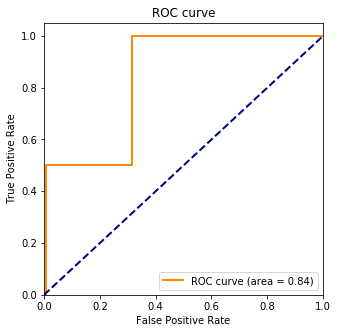

In [41]:
clf_lr = LogisticRegression()
y_pred = ml_classification(X, X_test, y, y_test, n_folds=5, model_type='sklearn',
                 columns=columns, model=clf_lr, roc=True)

In [42]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[661,   1],
       [ 30,   1]], dtype=int64)

## Decision Tree

Fold 1 startd at Thu Apr  9 23:03:48 2020

Fold 2 startd at Thu Apr  9 23:03:48 2020

Fold 3 startd at Thu Apr  9 23:03:48 2020

Fold 4 startd at Thu Apr  9 23:03:48 2020

Fold 5 startd at Thu Apr  9 23:03:48 2020



<Figure size 432x288 with 0 Axes>

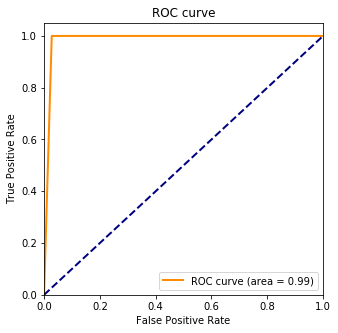

In [47]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=5,
                                 min_impurity_decrease=0.1)
y_pred = ml_classification(X, X_test, y, y_test, n_folds=5, model_type='sklearn',
                 columns=columns, model=clf_tree, roc=True)

In [48]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[672,   0],
       [ 19,   2]], dtype=int64)

## Random Forest

Fold 1 startd at Thu Apr  9 22:16:48 2020

Fold 2 startd at Thu Apr  9 22:16:48 2020

Fold 3 startd at Thu Apr  9 22:16:48 2020

Fold 4 startd at Thu Apr  9 22:16:48 2020

Fold 5 startd at Thu Apr  9 22:16:48 2020



<Figure size 432x288 with 0 Axes>

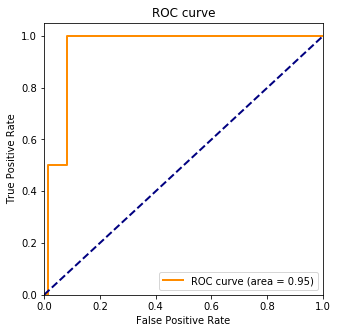

In [9]:
clf_rf = RandomForestClassifier(max_depth=5, n_estimators=10)
y_pred = ml_classification(X, X_test, y, y_test, n_folds=5, model_type='sklearn',
                 columns=columns, model=clf_rf, roc=True)

In [25]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[681,   1],
       [ 10,   1]], dtype=int64)

## XGBoost

Fold 1 startd at Thu Apr  9 22:18:39 2020
[0]	train-logloss:0.692164	valid_data-logloss:0.692186
Multiple eval metrics have been passed: 'valid_data-logloss' will be used for early stopping.

Will train until valid_data-logloss hasn't improved in 200 rounds.
Stopping. Best iteration:
[4850]	train-logloss:0.010067	valid_data-logloss:0.056477

Fold 2 startd at Thu Apr  9 22:19:16 2020
[0]	train-logloss:0.692169	valid_data-logloss:0.692204
Multiple eval metrics have been passed: 'valid_data-logloss' will be used for early stopping.

Will train until valid_data-logloss hasn't improved in 200 rounds.
Stopping. Best iteration:
[5823]	train-logloss:0.005213	valid_data-logloss:0.071997

Fold 3 startd at Thu Apr  9 22:20:01 2020
[0]	train-logloss:0.692174	valid_data-logloss:0.692178
Multiple eval metrics have been passed: 'valid_data-logloss' will be used for early stopping.

Will train until valid_data-logloss hasn't improved in 200 rounds.
[10000]	train-logloss:0.001872	valid_data-logloss:0.0

<Figure size 432x288 with 0 Axes>

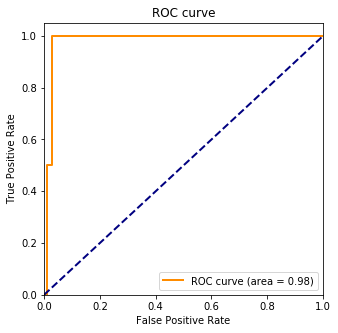

In [16]:
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.001,
    'gamma': 0.25,
    'subsample': 1,
    'verbosity': 0
}
y_pred = ml_classification(X, X_test, y, y_test, params=params_xgb,
                           n_folds=5, model_type='xgb',
                           columns=columns, roc=True)

In [24]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[681,   1],
       [ 10,   1]], dtype=int64)

# Global Crisis 20

In [28]:
X = GC20_Balanced
y = GC20_Balanced['Global.Crisis.20']
columns = [x for x in X.columns if x not in ['Date','Global.Crisis',
                                             'Global.Crisis.20']]
y_test = X_test['Global.Crisis.20']

## Logistic Regression

Fold 1 startd at Thu Apr  9 22:26:49 2020

Fold 2 startd at Thu Apr  9 22:26:49 2020

Fold 3 startd at Thu Apr  9 22:26:49 2020

Fold 4 startd at Thu Apr  9 22:26:50 2020


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Fold 5 startd at Thu Apr  9 22:26:50 2020



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

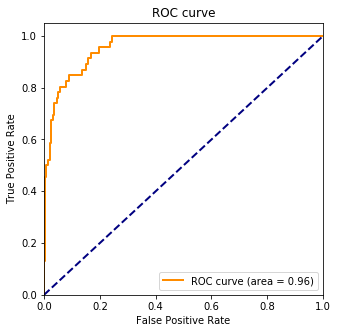

In [29]:
clf_lr = LogisticRegression()
y_pred = ml_classification(X, X_test, y, y_test, n_folds=5, model_type='sklearn',
                 columns=columns, model=clf_lr, roc=True)

In [30]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[593,   8],
       [ 54,  38]], dtype=int64)

## Decision Tree

Fold 1 startd at Thu Apr  9 22:28:33 2020

Fold 2 startd at Thu Apr  9 22:28:33 2020

Fold 3 startd at Thu Apr  9 22:28:33 2020

Fold 4 startd at Thu Apr  9 22:28:33 2020

Fold 5 startd at Thu Apr  9 22:28:33 2020



<Figure size 432x288 with 0 Axes>

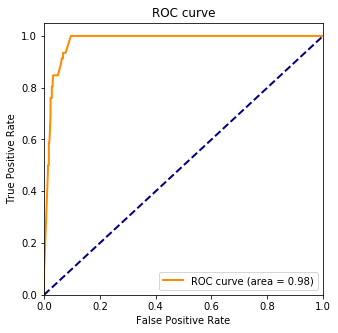

In [31]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=5,
                                 min_impurity_decrease=0.01)
y_pred = ml_classification(X, X_test, y, y_test, n_folds=5, model_type='sklearn',
                 columns=columns, model=clf_tree, roc=True)

In [32]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[584,   0],
       [ 63,  46]], dtype=int64)

## Random Forest

Fold 1 startd at Thu Apr  9 22:29:13 2020

Fold 2 startd at Thu Apr  9 22:29:13 2020

Fold 3 startd at Thu Apr  9 22:29:13 2020

Fold 4 startd at Thu Apr  9 22:29:13 2020

Fold 5 startd at Thu Apr  9 22:29:13 2020



<Figure size 432x288 with 0 Axes>

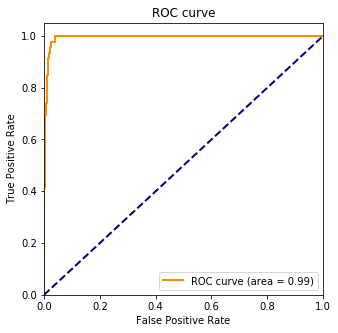

In [33]:
clf_rf = RandomForestClassifier(max_depth=5, n_estimators=10)
y_pred = ml_classification(X, X_test, y, y_test, n_folds=5, model_type='sklearn',
                 columns=columns, model=clf_rf, roc=True)

In [37]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[619,   0],
       [ 28,  46]], dtype=int64)

## XGBoost

Fold 1 startd at Thu Apr  9 22:30:07 2020
[0]	train-logloss:0.69223	valid_data-logloss:0.692322
Multiple eval metrics have been passed: 'valid_data-logloss' will be used for early stopping.

Will train until valid_data-logloss hasn't improved in 200 rounds.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stopping. Best iteration:
[9320]	train-logloss:0.003209	valid_data-logloss:0.048979

Fold 2 startd at Thu Apr  9 22:31:53 2020
[0]	train-logloss:0.692243	valid_data-logloss:0.692264
Multiple eval metrics have been passed: 'valid_data-logloss' will be used for early stopping.

Will train until valid_data-logloss hasn't improved in 200 rounds.
Stopping. Best iteration:
[9364]	train-logloss:0.003255	valid_data-logloss:0.023731

Fold 3 startd at Thu Apr  9 22:33:42 2020
[0]	train-logloss:0.692195	valid_data-logloss:0.692223
Multiple eval metrics have been passed: 'valid_data-logloss' will be used for early stopping.

Will train until valid_data-logloss hasn't improved in 200 rounds.
[10000]	train-logloss:0.003157	valid_data-logloss:0.012214
Stopping. Best iteration:
[11507]	train-logloss:0.002977	valid_data-logloss:0.012054

Fold 4 startd at Thu Apr  9 22:36:01 2020
[0]	train-logloss:0.692198	valid_data-logloss:0.692231
Multiple eval metrics have been passed: 'valid_data-logloss' will be u

<Figure size 432x288 with 0 Axes>

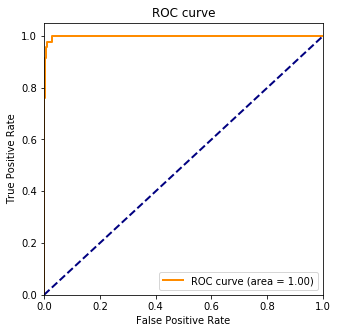

In [38]:
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.001,
    'gamma': 0.25,
    'subsample': 1,
    'verbosity': 0
}
y_pred = ml_classification(X, X_test, y, y_test, params=params_xgb,
                           n_folds=5, model_type='xgb',
                           columns=columns, roc=True)

In [39]:
confusion_matrix((y_pred > 0.5).astype('int'), y_test)

array([[640,   1],
       [  7,  45]], dtype=int64)